In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/20250103T03-00-00_20250110T03-00-00_7.csv")

# Bad Conditioned Nozzle
b_start_time = "20250106T4:12:00.000"
b_end_time = "20250106T4:39:59.000"
b_df = df[(df["TimeStamp"] >= b_start_time) & (df["TimeStamp"] <= b_end_time)].reset_index(drop=True)

# Bad Conditioned Nozzle
g_start_time = "20250106T6:38:00.000"
g_end_time = "20250106T7:05:59.000"
g_df = df[(df["TimeStamp"] >= g_start_time) & (df["TimeStamp"] <= g_end_time)].reset_index(drop=True)

b_df['Nozzle_Condition'] = 0
g_df['Nozzle_Condition'] = 1

print(f"Number of bad data points: {len(b_df)}")
print(f"Number of good data points: {len(g_df)}")


Number of bad data points: 1680
Number of good data points: 1680


In [2]:
import torch.nn as nn

class LSTMAnomalyDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMAnomalyDetector, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dense = nn.Linear(hidden_dim, output_dim)  # Ensure output matches target dim

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.dense(lstm_out[:, -1, :])  # Predicts last timestep
        return output  # Shape: (batch_size, output_dim)


In [3]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Define the relevant features
pros_param = ["Chamber_Pressure", "Main_Gas_Flow", "PF1_Pressure", "PF1_Gas_Flow"]

# Assuming g_df contains the good dataset and pros_param lists the relevant features
X = g_df[pros_param].values  # Extract features
y = np.zeros(len(X))  # Assuming all data is normal (good)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")

# Normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Function to create time-series data
def create_time_series(data, timesteps):
    samples = []
    for i in range(len(data) - timesteps + 1):
        samples.append(data[i:i + timesteps])
    return np.array(samples)

# Define the number of timesteps
timesteps = 60

# Create time-series data for train and test sets
X_train_series = create_time_series(X_train, timesteps)
X_test_series = create_time_series(X_test, timesteps)

# Adjust labels to match the windows (if needed)
y_train_series = y_train[timesteps - 1:]
y_test_series = y_test[timesteps - 1:]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_series, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_series, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_series, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_series, dtype=torch.float32)

# Print PyTorch tensor shapes
print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")


Original X_train shape: (1344, 4)
Original X_test shape: (336, 4)
X_train_tensor shape: torch.Size([1285, 60, 4])
X_test_tensor shape: torch.Size([277, 60, 4])
y_train_tensor shape: torch.Size([1285])
y_test_tensor shape: torch.Size([277])


In [4]:
import torch
import torch.nn as nn

# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
input_dim = X_train_series.shape[2]  # Number of features
hidden_dim = 64
output_dim = input_dim  # Ensure output matches input features
learning_rate = 0.0001
num_epochs = 50
batch_size = 32

# Move model to GPU
model = LSTMAnomalyDetector(input_dim, hidden_dim, output_dim).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Move data to GPU
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test_tensor, batch_size=batch_size, shuffle=False)

best_loss = float('inf')
patience = 5
trigger_count = 0

# Training Loop with GPU Support
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        batch = batch.to(device)  # Move batch to GPU

        # Training step
        optimizer.zero_grad()
        output = model(batch)

        loss = criterion(output, batch[:, -1, :])  # Ensure correct shape
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)  # Move batch to GPU

            output = model(batch)
            loss = criterion(output, batch[:, -1, :])
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_count = 0
        best_model = model.state_dict()
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print("Early stopping triggered!")
            model.load_state_dict(best_model)
            break


Using device: cuda
Epoch 1, Train Loss: 0.2016, Val Loss: 0.1710
Epoch 2, Train Loss: 0.1584, Val Loss: 0.1235
Epoch 3, Train Loss: 0.0945, Val Loss: 0.0435
Epoch 4, Train Loss: 0.0318, Val Loss: 0.0265
Epoch 5, Train Loss: 0.0282, Val Loss: 0.0263
Epoch 6, Train Loss: 0.0280, Val Loss: 0.0262
Epoch 7, Train Loss: 0.0279, Val Loss: 0.0261
Epoch 8, Train Loss: 0.0278, Val Loss: 0.0260
Epoch 9, Train Loss: 0.0277, Val Loss: 0.0259
Epoch 10, Train Loss: 0.0276, Val Loss: 0.0258
Epoch 11, Train Loss: 0.0275, Val Loss: 0.0257
Epoch 12, Train Loss: 0.0274, Val Loss: 0.0256
Epoch 13, Train Loss: 0.0273, Val Loss: 0.0255
Epoch 14, Train Loss: 0.0272, Val Loss: 0.0254
Epoch 15, Train Loss: 0.0271, Val Loss: 0.0253
Epoch 16, Train Loss: 0.0270, Val Loss: 0.0252
Epoch 17, Train Loss: 0.0268, Val Loss: 0.0251
Epoch 18, Train Loss: 0.0267, Val Loss: 0.0250
Epoch 19, Train Loss: 0.0266, Val Loss: 0.0248
Epoch 20, Train Loss: 0.0264, Val Loss: 0.0247
Epoch 21, Train Loss: 0.0263, Val Loss: 0.0246
Epo

In [5]:
model_save_path = "../trained_model/seq_to_1_lstm_glass_anomaly.pth"
torch.save(best_model, model_save_path)
print(f"Model checkpoint saved to {model_save_path}")

Model checkpoint saved to ../trained_model/seq_to_1_lstm_glass_anomaly.pth


In [6]:
# # Load the trained model
model_save_path = "../trained_model/lstm_glass_anomaly.pth"
model.load_state_dict(torch.load(model_save_path))

C:\Users\yongz\AppData\Local\Temp\ipykernel_33272\1133719170.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

## Elliptic Envelope on LSTM Reconstruction Error Distribution

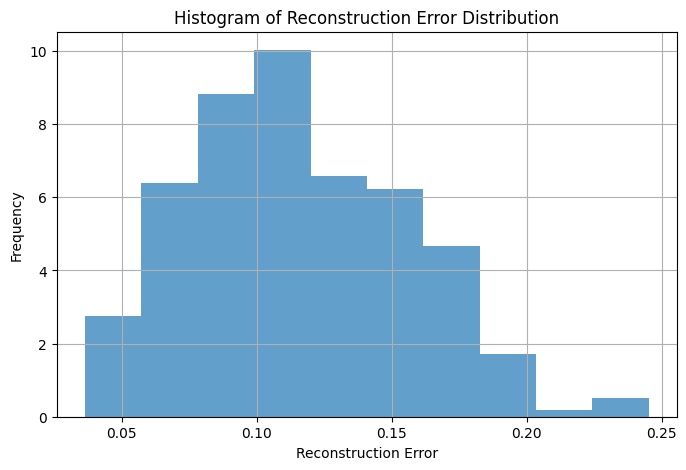

In [11]:
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt

# Model Evaluation
model.eval()
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_error = torch.mean(torch.abs(X_test_tensor[:, -1, :] - reconstructed), axis=1)

# Convert to NumPy
reconstruction_error_np = reconstruction_error.cpu().numpy().reshape(-1, 1)

# Train using normal data only (assume most data is normal)
elliptic_env = EllipticEnvelope(contamination=0.05)  # Assume 5% anomalies
elliptic_env.fit(reconstruction_error_np)


# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(reconstruction_error_np, bins=10, alpha=0.7, density=True)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Error Distribution")
plt.grid(True)

# Show the plot
plt.show()


In [16]:
import matplotlib.dates as mdates


def analyze_spray_data(df, start_time, end_time, spray_start_time, spray_end_time, model, scaler, pros_param, timesteps, elliptic_env, nozzle_condition):
    """
    Analyze spray data, detect anomalies using Elliptic Envelope, and compute the sum of MSE during spraying.

    Returns:
    - spray_data (DataFrame): Data with anomaly labels.
    """

    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format="%Y%m%dT%H:%M:%S.%f")

    # Convert string times to datetime
    start_time = pd.to_datetime(start_time, format="%Y%m%dT%H:%M:%S.%f")
    end_time = pd.to_datetime(end_time, format="%Y%m%dT%H:%M:%S.%f")
    spray_start_time = pd.to_datetime(spray_start_time, format="%Y%m%dT%H:%M:%S.%f")
    spray_end_time = pd.to_datetime(spray_end_time, format="%Y%m%dT%H:%M:%S.%f")

    # Filter the DataFrame to the defined time range
    df = df[(df['TimeStamp'] >= start_time) & (df['TimeStamp'] <= end_time)].reset_index(drop=True)
    spray_df = df[(df['TimeStamp'] >= spray_start_time) & (df['TimeStamp'] <= spray_end_time)].reset_index(drop=True)

    # Extract relevant features
    X_unseen = df[pros_param].values
    X_unseen_spray = spray_df[pros_param].values

    # Normalize data
    scaler = MinMaxScaler()
    X_unseen_scalar = scaler.fit(X_unseen_spray)
    X_unseen = X_unseen_scalar.transform(X_unseen)
    X_unseen_series = create_time_series(X_unseen, timesteps)

    # Convert to CUDA Tensor
    X_unseen_tensor = torch.tensor(X_unseen_series, dtype=torch.float32).to(device)

    # Maintain mapping between time-series windows and original indices
    original_indices = df.index[timesteps - 1:]

    # Move model to CUDA and evaluate
    model.to(device)
    model.eval()

    # Inference with LSTM model on GPU
    with torch.no_grad():
        reconstructed_new = model(X_unseen_tensor)
        reconstruction_error_new = torch.mean(torch.abs(X_unseen_tensor[:, -1, :] - reconstructed_new), axis=1)

    # Move data back to CPU
    reconstruction_error_np = reconstruction_error_new.cpu().numpy().reshape(-1)

    # # Train Elliptic Envelope on normal spray data
    # elliptic_env = EllipticEnvelope(contamination=contamination)
    # elliptic_env.fit(reconstruction_error_np.reshape(-1, 1))

    # Predict anomalies
    anomaly_predictions = elliptic_env.predict(reconstruction_error_np.reshape(-1, 1))

    # Map predictions to labels
    df['Label'] = 'Not Evaluated'
    df.loc[timesteps:, 'Label'] = 'Normal'
    df.loc[original_indices[np.where(anomaly_predictions == -1)[0]], 'Label'] = 'Anomaly'

    # Compute MSE sum during spray period
    spray_indices = (df['TimeStamp'] >= spray_start_time) & (df['TimeStamp'] <= spray_end_time)
    mse_sum_during_spray = np.sum(reconstruction_error_np[spray_indices[timesteps - 1:].to_numpy()])
    print(f"Sum of MSE during spraying: {mse_sum_during_spray:.6f}")

    # Count anomalies
    spray_data = df[(df['TimeStamp'] >= spray_start_time) & (df['TimeStamp'] <= spray_end_time)]
    normal_count = spray_data[spray_data['Label'] == 'Normal'].shape[0]
    anomaly_count = spray_data[spray_data['Label'] == 'Anomaly'].shape[0]
    total_data = normal_count + anomaly_count

    print(f"Normal Count: {normal_count}")
    print(f"Anomaly Count: {anomaly_count}")

    plt.figure(figsize=(14, 20))
    for i, feature in enumerate(pros_param):
        plt.subplot(len(pros_param), 1, i + 1)
        plt.plot(df['TimeStamp'], df[feature], label=feature, linewidth=0.7, color='grey', zorder=0)

        # Normal data
        normal_data = df[df['Label'] == 'Normal']
        plt.scatter(normal_data['TimeStamp'], normal_data[feature],
                    color='green', label=f'Normal (N={normal_count}, {(normal_count/total_data)*100:.1f}%))', marker='o', s=20)

        # Anomalous data
        anomaly_data = df[df['Label'] == 'Anomaly']
        plt.scatter(anomaly_data['TimeStamp'], anomaly_data[feature],
                    color='red', label=f'Anomaly (N={anomaly_count}, {(anomaly_count/total_data)*100:.1f}%))', marker='x', s=10)

        # Add vertical lines for spray start and end times
        plt.axvline(spray_start_time, color='black', linestyle='--', linewidth=1.2)
        plt.axvline(spray_end_time, color='black', linestyle='--', linewidth=1.2)

        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=5)) 
        plt.title(f"{feature} of {nozzle_condition} Nozzle", fontsize=14)
        plt.xlabel("Time", fontsize=12)
        plt.ylabel("Value", fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return reconstruction_error_np


Sum of MSE during spraying: 185.380157
Normal Count: 995
Anomaly Count: 190


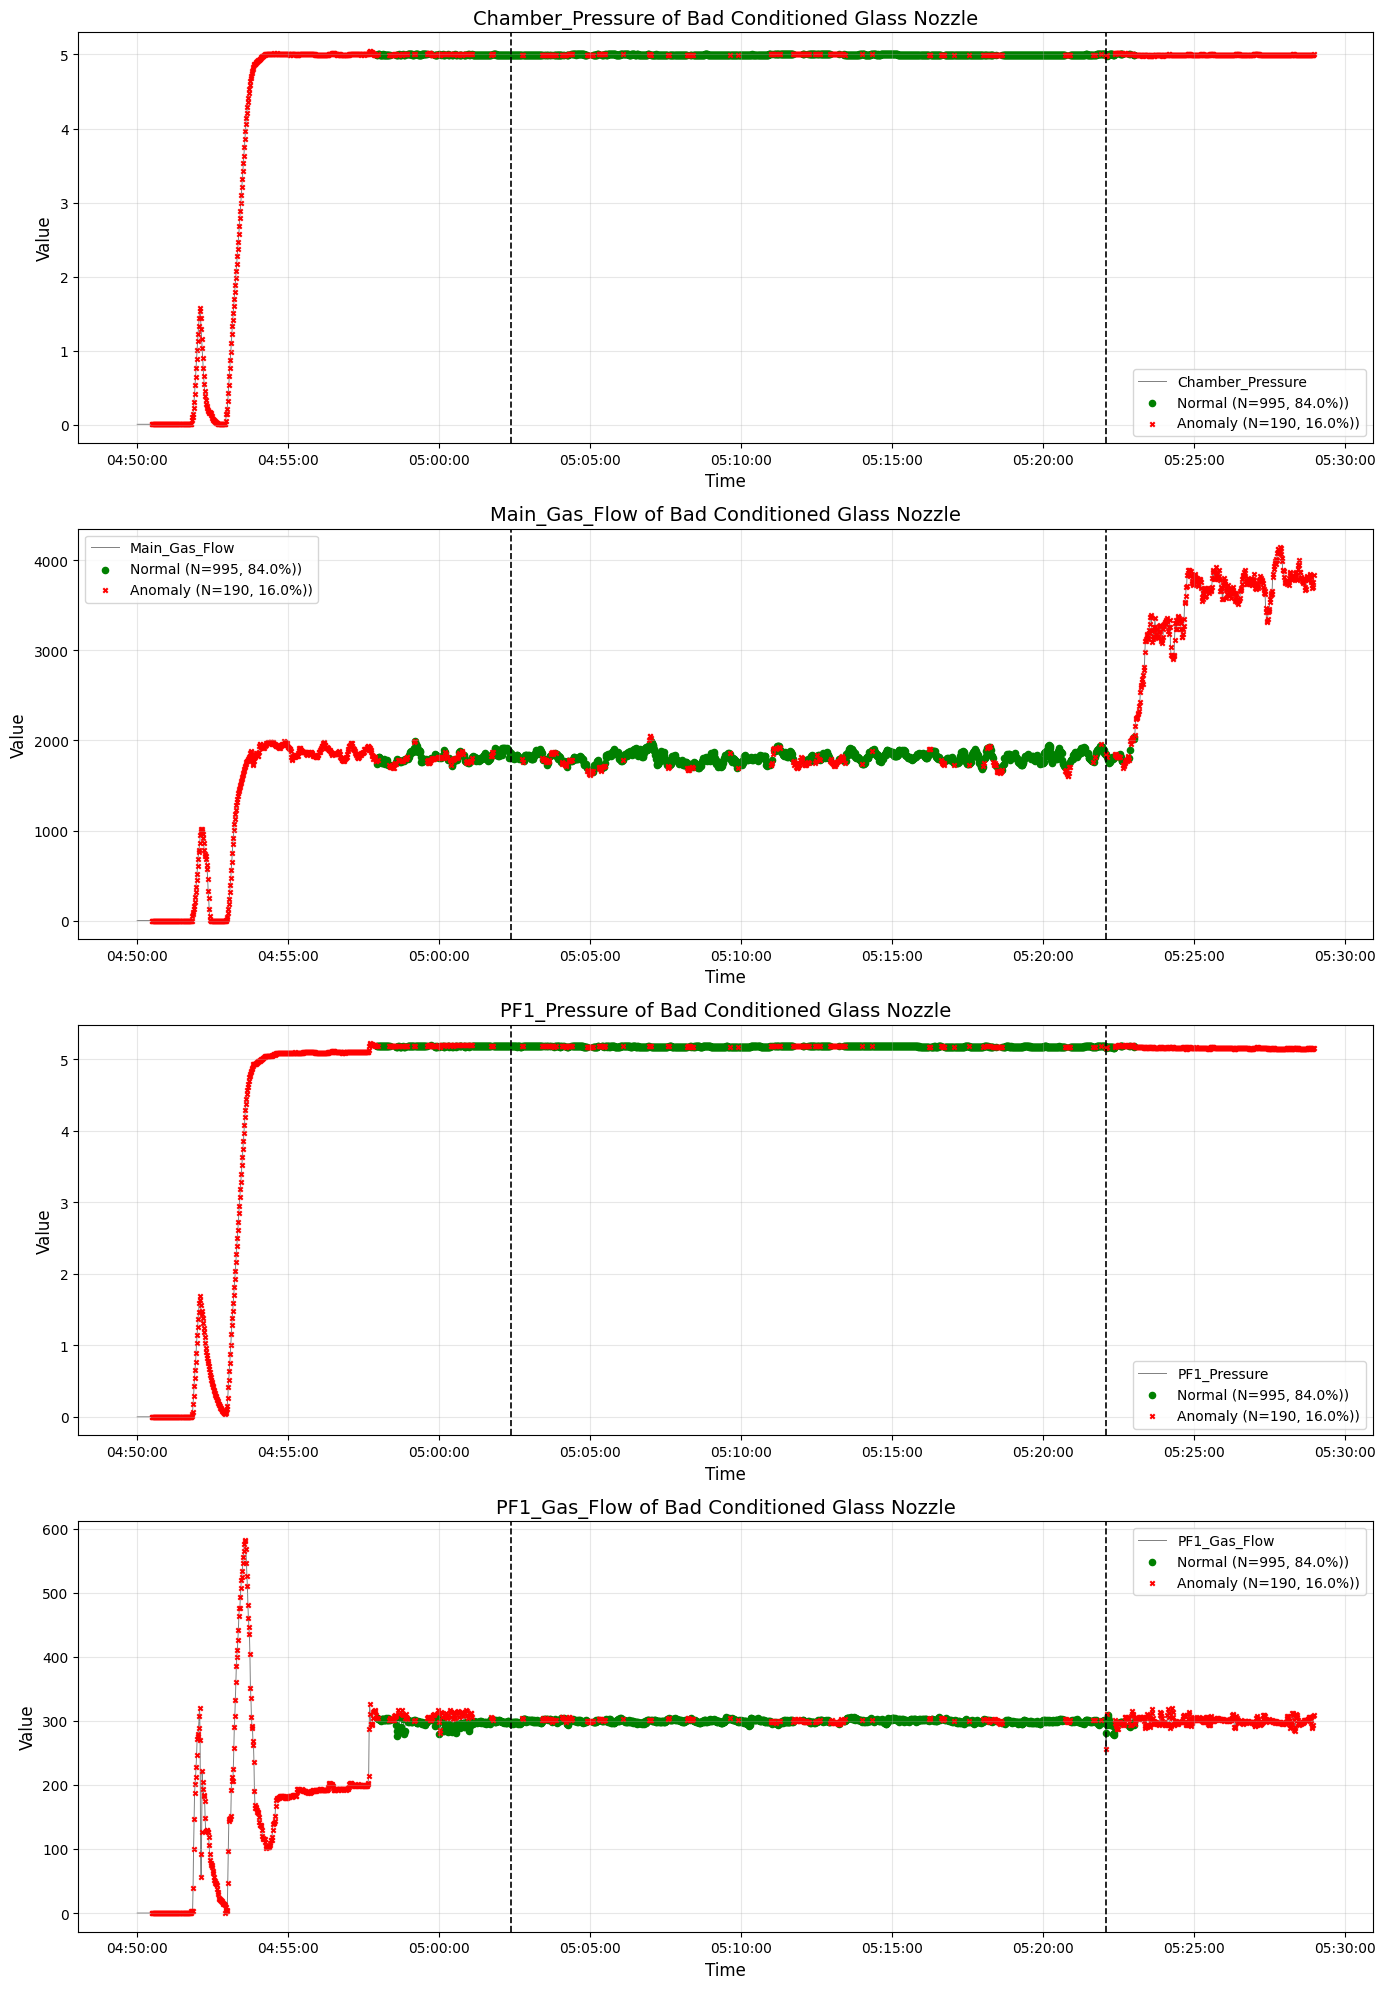

In [17]:
# Bad Nozzle

bad_spray_data = analyze_spray_data(
    df=pd.read_csv("../data/20250115_glass.csv"),
    start_time="20250115T04:50:00.010",
    end_time="20250115T05:28:59.014",
    spray_start_time="20250115T05:02:22.022",
    spray_end_time="20250115T05:22:06.006",
    model=model,
    scaler=scaler,
    pros_param=["Chamber_Pressure", "Main_Gas_Flow", "PF1_Pressure", "PF1_Gas_Flow"],
    timesteps=30,
    elliptic_env=elliptic_env,
    nozzle_condition="Bad Conditioned Glass"
)


Sum of MSE during spraying: 115.397774
Normal Count: 1096
Anomaly Count: 77


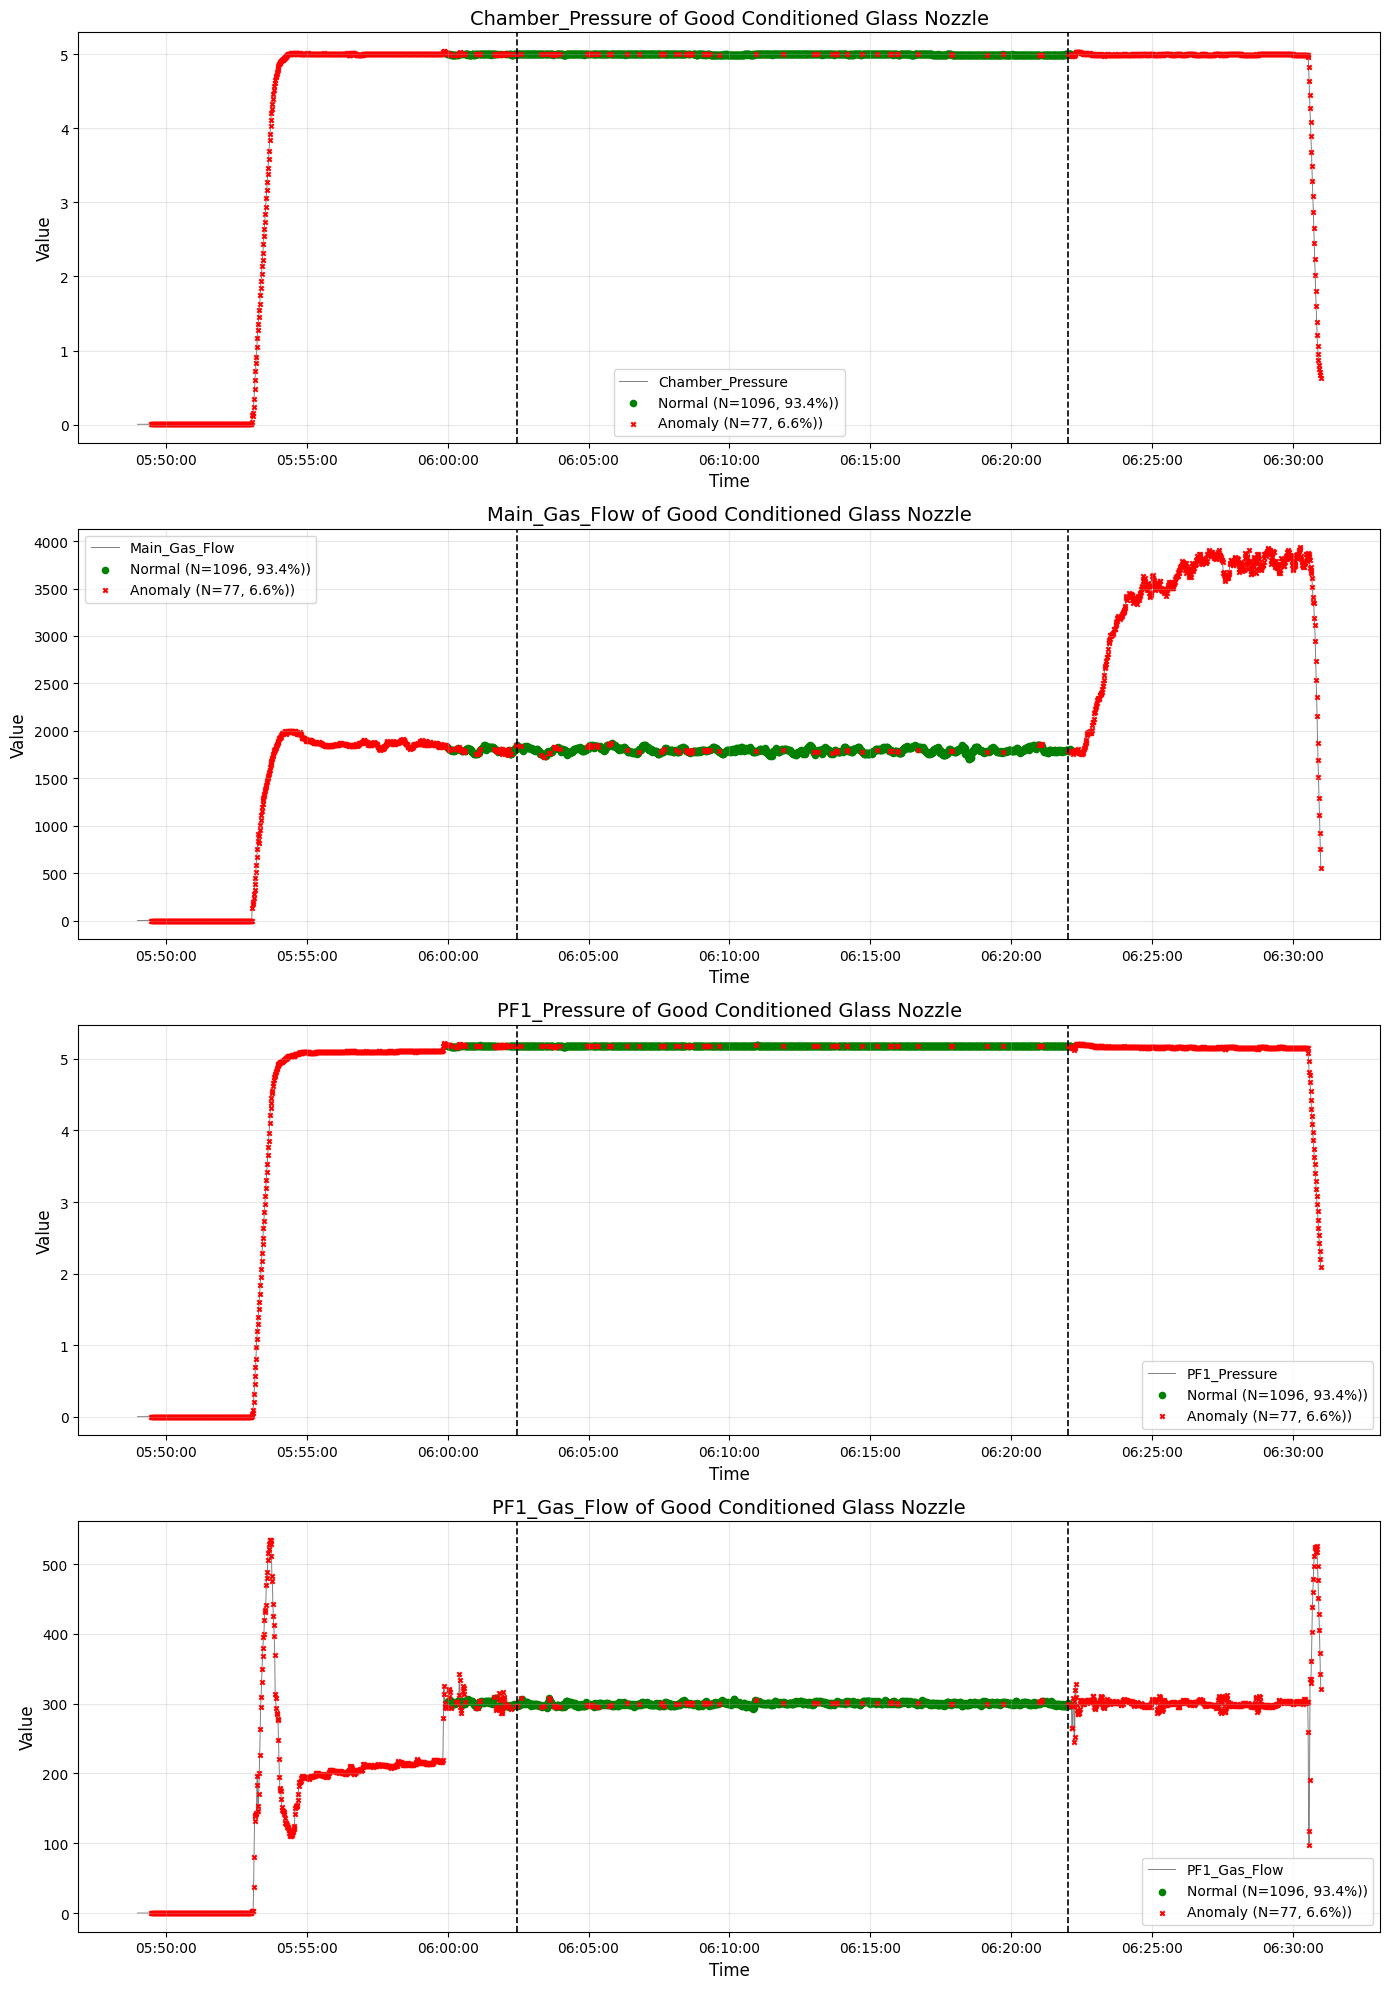

In [18]:
# Good Nozzle

good_spray_data = analyze_spray_data(
    df=pd.read_csv("../data/20250115_glass.csv"),
    start_time="20250115T05:49:00.014",
    end_time="20250115T06:30:59.006",
    spray_start_time="20250115T06:02:28.010",
    spray_end_time="20250115T06:22:00.005",
    model=model, 
    scaler=scaler,
    pros_param=["Chamber_Pressure", "Main_Gas_Flow", "PF1_Pressure", "PF1_Gas_Flow"],
    timesteps=30,
    elliptic_env=elliptic_env,
    nozzle_condition="Good Conditioned Glass"
)


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(bad_spray_data[700:1000])
plt.show()



In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(good_spray_data[900:1800])
plt.show()



In [13]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# def plot_anomalies_grid(df, pros_param, title):
#     """
#     Visualize anomalies for each parameter in a grid.

#     Parameters:
#     - df: DataFrame containing the data to plot.
#     - pros_param: List of parameters to plot.
#     - title: Title for the plot.
#     """
#     # Create subplots
#     num_params = len(pros_param)
#     if num_params == 1:
#         fig, ax = plt.subplots(figsize=(14, 6))  # Single subplot for one parameter
#         axes = [ax]  # Wrap it in a list for consistent indexing
#     else:
#         fig, axes = plt.subplots(num_params, 1, figsize=(14, num_params * 6))  # Multiple subplots

#     for i, param in enumerate(pros_param):
#         ax = axes[i] if num_params > 1 else axes[0]  # Handle single or multiple subplots
#         normal_data = df[df['Label'] == 'Normal']
#         slight_anomalies = df[df['Label'] == 'Slight Abnormal']
#         heavy_anomalies = df[df['Label'] == 'Heavy Abnormal']

#         total_count = len(normal_data) + len(slight_anomalies) + len(heavy_anomalies)

#         # Plot data
#         ax.plot(df['TimeStamp'], df[param], linewidth=0.7, color='grey', zorder=0, label=pros_param[i])
#         ax.scatter(normal_data['TimeStamp'], normal_data[param], color='green', label=f'Normal (N={len(normal_data)}, {(len(normal_data)/total_count)*100:.1f}%)', marker='.')
#         ax.scatter(slight_anomalies['TimeStamp'], slight_anomalies[param], color='orange', label=f'Slight Anomaly (N={len(slight_anomalies)}, {(len(slight_anomalies)/total_count)*100:.1f}%)', marker='x')
#         ax.scatter(heavy_anomalies['TimeStamp'], heavy_anomalies[param], color='red', label=f'Heavy Abnormal (N={len(heavy_anomalies)}, {(len(heavy_anomalies)/total_count)*100:.1f}%)', marker='x')

#         # Add vertical lines for start and end times
#         ax.axvline(df['TimeStamp'].iloc[0], color='black', linestyle='--', linewidth=1.2)
#         ax.axvline(df['TimeStamp'].iloc[-1], color='black', linestyle='--', linewidth=1.2)

#         # Set x-axis formatting
#         ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#         ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))

#         # Set titles, labels, and limits
#         ax.set_title(f'{param} of {title}', fontsize=18)
#         ax.set_xlabel('Time Stamp', fontsize=14)
#         ax.set_ylabel(param, fontsize=14)
#         ax.set_ylim((1600, 2100))  # Adjust y-axis range if needed
#         # ax.legend()

#     # Adjust layout to prevent overlap
#     plt.tight_layout()
#     plt.show()


In [14]:
# pros_param = ["Main_Gas_Flow"]
# title = "Bad Condition Glass Nozzle"

# # Call the function to plot the anomalies
# plot_anomalies_grid(bad_spray_data, pros_param, title)

In [15]:
# pros_param = ["Main_Gas_Flow"]
# title = "Good Condition Glass Nozzle"

# # Call the function to plot the anomalies
# plot_anomalies_grid(good_spray_data, pros_param, title)